# import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
from nilearn.input_data import NiftiLabelsMasker
from nilearn import input_data, datasets
from nilearn import plotting
from nilearn.image import new_img_like
import nilearn
import pandas as pd
import scipy

### define a helper function to read the onset/name files
def read_onsets(curr_subject):
    df = pd.read_csv('../data_realcost/onsets/Onsets_RealCost_View_' + curr_subject + '.csv', encoding="ISO-8859-1") 
    df = df[df.PSA != 'Count']
    df = df[df.PSA != 'Imagine'] 
    df = df.PSA.values
    spot_names = []
    for i in range(len(df)):
        spot_names.append(df[i][:-5])
    return spot_names

c:\users\shelby\anaconda3\envs\shelby_neuroimaging\lib\site-packages\nilearn\datasets\__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
#1 set up the files 1 masker file, 1 funct file, import relevant stuff
atlas_filename  = '../data_realcost/masker/shen_2mm_268_parcellation.nii'
sample_file     = '../data_realcost/masker/func.nii' #just sample data for fitting 

shen_file       = '../data_realcost/masker/shen_2mm_268_parcellation.nii'

shen_masker = input_data.NiftiLabelsMasker(shen_file, 
                                             detrend     = True, 
                                             standardize = True,
                                             high_pass   = 0.01, 
                                             t_r         = 1.0,  #check!
                                             low_pass    = 0.12 );

#2 set up the masker and fit it on some file
shen_masker     = NiftiLabelsMasker(labels_img= atlas_filename);
shen_masker.fit_transform(sample_file);


### define onsets and subjs

In [2]:
onsets_view   =  [6, 66, 127, 187, 248, 308, 369, 429, 490, 550, 611, 671]
print(len(onsets_view))

onsets_imagine = [47,108,168, 229, 289, 350, 410, 471, 531, 592, 652, 713]
print(len(onsets_imagine))

spots = ['01_The Real Cost Commercial-Your Skin',
         '02_The Real Cost Commercial-Your Teeth',
         '03_The Real Cost Commercial-Alison',
         '04_The Real Cost Commercial-Stay In Control',
         '05_The Real Cost Commercial-Bully',
         '06_The Real Cost Commercial-#7000chemicals',
         '07_The Real Cost Commercial-Dance30_2015_04_10_TESFA',
         '08_The Real Cost Commercial-Band_30_2015_04_10_TESFA',
         '09_The Real Cost Commercial-#ReasonsNotToSmoke',
         '10_The Real Cost Commercial-Any Reason',
         '11_The Real Cost Commercial-Science Class',
         '12_The Real Cost Commercial-Found It']
n_spots = len(spots)
print(n_spots)

subjs = ['PSA038','PSA009','PSA078','PSA153','PSA131','PSA086','PSA144','PSA108','PSA030','PSA041',
         'PSA068','PSA056','PSA132','PSA019','PSA027','PSA028','PSA016','PSA005','PSA061','PSA010',
         'PSA128','PSA003','PSA156','PSA119','PSA032','PSA127','PSA079','PSA094','PSA008','PSA036',
         'PSA112','PSA007','PSA151','PSA120','PSA017','PSA029','PSA026','PSA069','PSA142','PSA109']
n_subjs = len(subjs)
print(len(subjs))

view_length    = 30
imagine_length = 10
tr_shift = 4 

12
12
12
40


### load one person's fMRI data  and that person's onset-file

In [211]:
# this sets up the nested dictionary, which will later be populated with subject- and spot-wise data
subjs_spots_data = {}


# loop over subjects
for curr_subj in range(n_subjs):
    this_subj_name = subjs[curr_subj]
    #print(this_subj_name)
    
    # setting up a field in the nested dictionary
    subjs_spots_data[this_subj_name] = {}

    # loop over 12 spots
    for curr_spot in range(12):
       # print(curr_spot)

        # which file shall we load?
        curr_file   = '../data_realcost/' + subjs[curr_subj] + '_shen_extracted_hp001_lp012_ltr_stand.npy'

        # read this file, i.e. the 735 by 268 'data-carpet', 735 TRs (time) by 268 (regions)
        current_time_series = np.load(curr_file)
        #print(current_time_series.shape)

        # read the corresponding onset-file for this subject: this will tell us when which PSA was shown etc.
        this_subj_spots = read_onsets(subjs[curr_subj]) #PSA003
        #print(*this_subj_spots, sep = "\n")
        #print('-----')
        #print(this_subj_spots[curr_spot])

        # extract - for the current spot - the data: OF note, at this point, we're just extracting the simple mean, 
        # i.e. we average over the whole viewing/imagining duration - 30/15 seconds
        # note: might have to correct for TR-shift - double check
        view_ad_1   = np.mean(current_time_series[onsets_view[curr_spot]+tr_shift: (onsets_view[curr_spot]+view_length+tr_shift), :], axis = 0)
        #print(view_ad_1.shape)

        imagine_ad_1   = np.mean(current_time_series[onsets_imagine[curr_spot]+tr_shift: (onsets_imagine[curr_spot]+imagine_length+tr_shift), :], axis = 0)
        #print(imagine_ad_1.shape)

        # now, having extracted the data, we can add them to a dictionary for later use
        # add the new spot based on its name (this_subj_spots[curr_spot]) to the dictionary
        subjs_spots_data[this_subj_name][this_subj_spots[curr_spot]] = {}

        # then populate this dictionary entry with the values 
        subjs_spots_data[this_subj_name][this_subj_spots[curr_spot]]['position']     = curr_spot;    # which count 0-11 (or 1-12)
        subjs_spots_data[this_subj_name][this_subj_spots[curr_spot]]['view_data']    = view_ad_1;    # the vector corresponding to viewing
        subjs_spots_data[this_subj_name][this_subj_spots[curr_spot]]['imagine_data'] = imagine_ad_1; # the vector corresponding to imagining



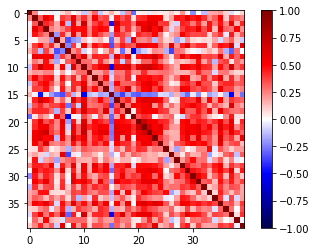

In [5]:
data_concat = []
for curr_subj in range(n_subjs):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    curr_data = subjs_spots_data[the_subj_name]['04_The Real Cost Commercial-Stay In Control']['view_data']
    data_concat.append(curr_data)
    
dataall = np.asarray(data_concat)
dataall.shape

plt.imshow(dataall)

plt.imshow(np.corrcoef(dataall), vmin = -1, vmax = 1, cmap = 'seismic')
plt.colorbar()

In [6]:
np.corrcoef(dataall)[0,1]

0.24207100618136454

### set up nested dictionary

array([[ 1.       , -0.4695918],
       [-0.4695918,  1.       ]])

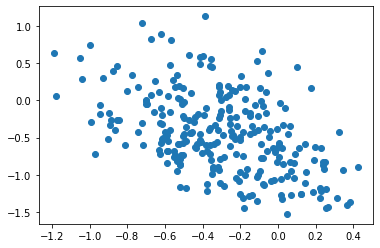

In [7]:

v = subjs_spots_data['PSA038']['04_The Real Cost Commercial-Stay In Control']['view_data'] 
i = subjs_spots_data['PSA038']['04_The Real Cost Commercial-Stay In Control']['imagine_data'] 


plt.scatter(v,i)
np.corrcoef(v, i)

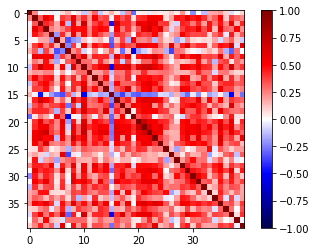

In [8]:
data_concat = []
for curr_subj in range(n_subjs):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    curr_data = subjs_spots_data[the_subj_name]['04_The Real Cost Commercial-Stay In Control']['view_data']
    data_concat.append(curr_data)
    
dataall = np.asarray(data_concat)
dataall.shape

plt.imshow(dataall)

plt.imshow(np.corrcoef(dataall), vmin = -1, vmax = 1, cmap = 'seismic')
plt.colorbar()

In [8]:
withincorrs = []
betweencorrs = []

for curr_subj_a in range(n_subjs): #1,2,3 ...
    this_subj_a = subjs[curr_subj_a]
    #print(this_subj_a)
    
    for curr_subj_b in range(curr_subj_a+1, n_subjs):
        this_subj_b = subjs[curr_subj_b]
        #print(this_subj_a)
        #print(this_subj_b)
        
        for curr_spot_a in range(n_spots):
            this_spot_a = spots[curr_spot_a]
            #print(this_spot_a)
            
            for curr_spot_b in range(curr_subj_a, n_spots):
                this_spot_b = spots[curr_spot_b]
                #print(this_spot_b)
                
                view_a =  subjs_spots_data[this_subj_a][this_spot_a]['view_data'] 
                view_b =  subjs_spots_data[this_subj_b][this_spot_b]['view_data'] 
                c_ab = np.corrcoef(view_a, view_b)[0,1]
                
                if (this_spot_a == this_spot_b):
                    #print('---')
                    #print('match')
                    #print(this_spot_a)
                    #print(this_spot_b)
                    #print('---')
                    withincorrs.append(c_ab)
                else:
                    betweencorrs.append(c_ab)


                
        
        #print('----')
    #print('----')


In [334]:
withincorrs_same_ad = []
same_view_ads = []
same_imagine_ads = []


for curr_subj in range(n_subjs): #1,2,3 ...
    this_subj = subjs[curr_subj]
    #print(this_subj)
    
    for curr_spot_a in range(n_spots):
        this_spot_a = spots[curr_spot_a]
                    
        view_ad =  subjs_spots_data[this_subj][this_spot_a]['view_data'] 
        imagine_ad =  subjs_spots_data[this_subj][this_spot_a]['imagine_data'] 
        same_ad = np.corrcoef(view_ad, imagine_ad)[0,1]
                        
        #look at a vectors using view ad , imagine_ad
        same_view_ads.append(view_ad)
        same_imagine_ads.append(imagine_ad)
        withincorrs_same_ad.append(same_ad)
       # print(this_spot_a)
       # print(same_ad)
        
same_view_array = np.asarray(same_view_ads)
same_view_array.shape

(480, 268)

In [135]:
view_half1 = []
view_half2 = []

#for every ad 
for curr_spot_a in range(n_spots):
    
    this_spot_a = spots[curr_spot_a]
    
    for curr_subj in range(20):
        this_subj =subjs[curr_subj]
       # print(this_subj)
       # print(this_spot_a)
        #correlate half the subjects to the other half
        view_ad_half1 =  subjs_spots_data[this_subj][this_spot_a]['view_data']
        view_half1.append(view_ad_half1)
       
        
    
    curr_subj_2 = 39
    
    while curr_subj_2 >= 20 :
        this_subj_2 =subjs[curr_subj_2]
        view_ad_half2 =  subjs_spots_data[this_subj_2][this_spot_a]['view_data']
        view_half2.append(view_ad_half2)
        #print(view_ad_half2)
        curr_subj_2 -= 1

view_half1array = np.asarray(view_half1)
view_half2array = np.asarray(view_half2)
print(view_half1array.shape)

(240, 268)


In [133]:
view_half1 = []
view_half2 = []

#for every ad 
    
for curr_subj in range(20):
    this_subj =subjs[curr_subj]
    
    for curr_spot_a in range(n_spots):
        this_spot_a = spots[curr_spot_a]
        print(this_subj)
        print(this_spot_a)
        #correlate half the subjects to the other half
        view_ad_half1 =  subjs_spots_data[this_subj][this_spot_a]['view_data']
        view_half1.append(view_ad_half1)
       
        
    
    curr_subj_2 = 39
    
while curr_subj_2 >= 20 :
    this_subj_2 =subjs[curr_subj_2]
    
    for curr_spot_a in range(n_spots):
        this_spot_a = spots[curr_spot_a]
        
        
        view_ad_half2 =  subjs_spots_data[this_subj_2][this_spot_a]['view_data']
        view_half2.append(view_ad_half2)
        #print(view_ad_half2)
        curr_subj_2 -= 1

view_half1array = np.asarray(view_half1)
view_half2array = np.asarray(view_half2)
print(np.corrcoef(view_half1array,view_half2array)[0,1])

PSA038
01_The Real Cost Commercial-Your Skin
PSA038
02_The Real Cost Commercial-Your Teeth
PSA038
03_The Real Cost Commercial-Alison
PSA038
04_The Real Cost Commercial-Stay In Control
PSA038
05_The Real Cost Commercial-Bully
PSA038
06_The Real Cost Commercial-#7000chemicals
PSA038
07_The Real Cost Commercial-Dance30_2015_04_10_TESFA
PSA038
08_The Real Cost Commercial-Band_30_2015_04_10_TESFA
PSA038
09_The Real Cost Commercial-#ReasonsNotToSmoke
PSA038
10_The Real Cost Commercial-Any Reason
PSA038
11_The Real Cost Commercial-Science Class
PSA038
12_The Real Cost Commercial-Found It
PSA009
01_The Real Cost Commercial-Your Skin
PSA009
02_The Real Cost Commercial-Your Teeth
PSA009
03_The Real Cost Commercial-Alison
PSA009
04_The Real Cost Commercial-Stay In Control
PSA009
05_The Real Cost Commercial-Bully
PSA009
06_The Real Cost Commercial-#7000chemicals
PSA009
07_The Real Cost Commercial-Dance30_2015_04_10_TESFA
PSA009
08_The Real Cost Commercial-Band_30_2015_04_10_TESFA
PSA009
09_The Rea

In [10]:
withincorrs_dif_ad = []

            
for curr_subj in range(n_subjs): #1,2,3 ...
    this_subj = subjs[curr_subj]
    #print(this_subj)
    
    for curr_spot_a in range(n_spots):
        this_spot_a = spots[curr_spot_a]
        
        
        for curr_spot_b in range(n_spots):
            this_spot_b = spots[curr_spot_b]
            
            
            view_ad_a =  subjs_spots_data[this_subj][this_spot_a]['view_data'] 
            imagine_ad_b =  subjs_spots_data[this_subj][this_spot_b]['imagine_data'] 
            dif_ad = np.corrcoef(view_ad_a, imagine_ad_b)[0,1]
            
            if (this_spot_a != this_spot_b):
                    #print('---')
                    #print('dif')
                    #print(this_spot_a)
                    #print(this_spot_b)
                    #print('---')
                    #print(curr_spot_a)
                    #print(curr_spot_b)
                    #print('----')
                    withincorrs_dif_ad.append(dif_ad)
                
            
           
       # print(this_spot_a)
       # print(same_ad)

                
        
        #print('----')
    #print('----')
    
#cor_view_to_reimagine = np.corrcoef(view_ad, imagine_ad)
#cor_view_to_reimagine

#print(withincorrs_same_ad)
#ad_array = np.asarray(view_ads)
#imagine_array = np.asarray(imagine_ads)
same_ad_array = np.asarray(withincorrs_same_ad)
dif_ad_array = np.asarray(withincorrs_dif_ad)
#np.shape(same_ad_array)
#np.shape(dif_ad_array)

same_ad_avg = np.mean(same_ad_array)
dif_ad_avg = np.mean(dif_ad_array)

print(same_ad_avg)
print(dif_ad_avg)
len(withincorrs_dif_ad)

-0.47007879156733096
-0.21052687782363072


5280

In [62]:
#plt.imshow(np.corrcoef(ad_array,imagine_array), cmap = 'RdPu', vmin = -1, vmax = 1);
#plt.colorbar()

In [49]:
w = np.asarray(withincorrs)
b = np.asarray(betweencorrs)
len(b)

30316

In [ ]:
#figures to add to powerpoint, only do if my notebook really unreadable 
#visualize activity 
#compare 20 to 20 subjects, make a subplot comparing view and imagine 

In [13]:
np.mean(withincorrs)

0.31652091639471136

In [14]:
np.mean(betweencorrs)

0.2508461622719647

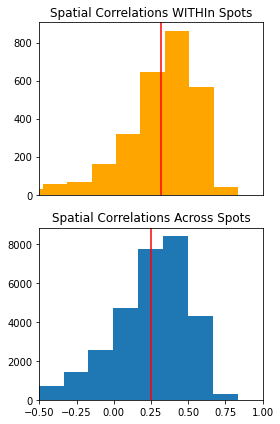

In [15]:
plt.figure(figsize = (4,6))
plt.subplot(2,1,1)
plt.hist(withincorrs, color = 'orange')
plt.axvline(np.mean(withincorrs), color = 'r')
plt.title('Spatial Correlations WITHIn Spots')
plt.xlim(-.5,1)
plt.xticks([])


plt.subplot(2,1,2)
plt.hist(betweencorrs)
plt.axvline(np.mean(betweencorrs), color = 'r')
plt.xlim(-.5,1)
plt.title('Spatial Correlations Across Spots')
plt.tight_layout()



In [17]:
scipy.stats.ttest_ind(withincorrs, betweencorrs)

Ttest_indResult(statistic=13.158295474145326, pvalue=1.916210370065295e-39)

array([[1.        , 0.24207101],
       [0.24207101, 1.        ]])

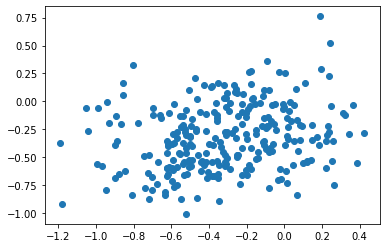

In [18]:
v = subjs_spots_data['PSA038']['04_The Real Cost Commercial-Stay In Control']['view_data'] 
i = subjs_spots_data['PSA009']['04_The Real Cost Commercial-Stay In Control']['view_data'] 


plt.scatter(v,i)
np.corrcoef(v, i)